In [1]:
import torch
import torch.nn.functional as F
import monai
import matplotlib.pyplot as plt
import time
import os
from matplotlib.colors import ListedColormap

from segm.model.factory import create_segmenter
from segm.model.policy_net import PolicyNetTrain


c:\Users\David\.conda\envs\CandidateNet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
#train_folder = '/media/david/T7/Kvasir-SEG/train'
#val_folder = '/media/david/T7/Kvasir-SEG/validation'
#test_folder = '/media/david/T7/Kvasir-SEG/test'
train_folder = r'D:\Datasets\Kvasir-SEG\train'
val_folder = r'D:\Datasets\Kvasir-SEG\validation'
test_folder = r'D:\Datasets\Kvasir-SEG\test'


In [4]:
def kvasir_data_to_dict(folder):
    images = os.listdir(os.path.join(folder, 'images'))
    data_list_dict = []
    for i in images:
        try:     
            if os.path.exists(os.path.join(folder, 'masks', i)):
                data_dict = {'image': os.path.join(folder, 'images', i),
                             'label': os.path.join(folder, 'masks', i)}
                data_list_dict.append(data_dict)
        except Exception as e:
            print("Failed to find label file {} with exception {}".format(i, e))
    
    return data_list_dict
    

In [5]:
def create_policy_labels(labels, patch_size): 
    super_patch_size = patch_size * 2
    max = F.max_pool2d(labels.float(), super_patch_size, stride=super_patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), super_patch_size, stride=super_patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.long).squeeze(0)

In [6]:
def train_policy_net(train_loader, patch_size):
    lr = 5e-5
    weight_decay = 1e-3
    num_iterations = 500
    log_iterations = 50
    enable_cuda = True
    
    model = PolicyNetTrain()
    model.train()
    model = model.cuda()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    i = 0
    running_loss = 0.0
    while i < num_iterations:
        for batch in train_loader:
            inputs, labels = (batch["image"], batch["label"])
            inputs = inputs.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            policy_labels = create_policy_labels(labels, patch_size)
            optimizer.zero_grad()
            out = model(inputs, policy_labels.squeeze())
            loss = out['loss']
            running_loss += out['loss'].item()
            loss.backward()
            optimizer.step()
            
        if i % log_iterations == 0:
            if i == 0:
                loss_avg = running_loss
            else:
                loss_avg = running_loss/log_iterations
            print("Iteration {} - Loss: {} \n".format(i, round(loss_avg, 5)))
            running_loss = 0.0 
            torch.save(model.state_dict(), 'policy_net_kvasir_{}.pth'.format(i))
        
        i += 1
        
    print("Finished training.")
    torch.save(model.state_dict(), 'policy_net_kvasir_final.pth')
    print("Saved trained model as policy_net.pth")    

In [7]:
train_data = kvasir_data_to_dict(train_folder)
val_data = kvasir_data_to_dict(val_folder)
test_data = kvasir_data_to_dict(test_folder)
#subtrahend=[142.12, 82.04, 60.13], divisor=[20.95, 11.46, 12.36]


In [8]:
transform_list = [monai.transforms.LoadImaged(keys=['image', 'label']),
            monai.transforms.EnsureChannelFirstD(keys=['image', "label"]),
            monai.transforms.NormalizeIntensityd(keys=['image'], divisor=[255, 255, 255], channel_wise=True),
            monai.transforms.ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255, b_min=0, b_max=1,clip=True),
            monai.transforms.Resized(keys=["image"], spatial_size=(512, 512), mode='bilinear'),
            monai.transforms.Resized(keys=["label"], spatial_size=(512, 512), mode='nearest')]

aug_list = [monai.transforms.RandRotate90d(keys=['image', 'label'], prob=0.1),
            monai.transforms.RandGibbsNoised(keys=['image'], prob=0.1),
            monai.transforms.RandAdjustContrastd(keys=['image'], prob=0.1),
            monai.transforms.RandZoomd(keys=['image', 'label'], prob=0.1, min_zoom=0.8, max_zoom=1.2)
            ]
transform_list_train = transform_list + aug_list

transform_list_train = transform_list
transform_list_train.append(monai.transforms.ToTensord(keys=["image", "label"]))

transform_list_val = transform_list
transform_list_val.append(monai.transforms.ToTensord(keys=["image", "label"]))

transforms_train = monai.transforms.Compose(transform_list_train)
transforms_val = monai.transforms.Compose(transform_list_val)

train_dataset = monai.data.Dataset(train_data, transform=transforms_train)
val_dataset = monai.data.Dataset(val_data, transform=transforms_val)

In [9]:
data_loader_val = monai.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True
    )

data_loader_train = monai.data.DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
    )

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
def visualize_data(im, lab):
    plt.figure()
    if im is not None:
        if im.shape[0] < 4:
            im = im.permute(1, 2, 0)
        if im.min() < 0:
            im += abs(im.min())
        plt.imshow(im.squeeze().cpu().numpy())
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    else:
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none')

In [12]:
def visualize_patches_scale(patches_scale_coords, n_scales, initial_patch_size, image_size, org_image=None, labels=None):
    colormap = ListedColormap(['silver', 'chocolate', 'blue', 'green', 'orange', 'magenta', 'red', 'lime'])
    full_image = torch.zeros(image_size[0] * image_size[1])
    for scale in range(n_scales):
        patch_size = initial_patch_size // 2**scale
        indx_curr_scale = patches_scale_coords[:, 0] == scale
        coords_at_curr_scale = patches_scale_coords[indx_curr_scale, 1]
        coords_at_org_scale = convert_scale_to_coords_in_full_res(coords_at_curr_scale, patch_size, image_size[0])
        full_image[coords_at_org_scale] = scale
    full_image = full_image.view(image_size[0], image_size[1])
    if org_image is not None:
        if org_image.shape[0] < 4:
            org_image = org_image.permute(1, 2, 0)
        plt.imshow(org_image.squeeze().cpu().numpy(), cmap='gray')
    if labels is not None:
        plt.imshow(labels.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    plt.imshow(full_image.squeeze().cpu().numpy(), interpolation='none', alpha=0.9, cmap=colormap)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2985333].


torch.Size([3, 512, 512])


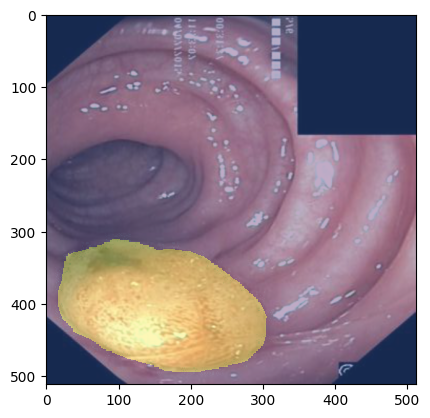

In [13]:
out = data_loader_train.dataset.__getitem__(246)
example_inputs = out['image']
example_labels = out['label']
example_inputs = example_inputs.to(device, non_blocking=True)
example_labels = example_labels.to(device, non_blocking=True)
print(example_inputs.shape)
visualize_data(example_inputs, example_labels)

In [14]:
model_cfg = {}
model_cfg["image_size"] = (512, 512)
model_cfg["patch_size"] = 16
model_cfg["d_model"] = 128
model_cfg["n_heads"] = 8
model_cfg["n_layers"] = 4
model_cfg["normalization"] = 'vit'
model_cfg["distilled"] = False
model_cfg["backbone"] = 'custom'
model_cfg["dropout"] = 0.0
model_cfg["drop_path_rate"] = 0.0
model_cfg["n_cls"] = 2
model_cfg["policy_method"] = 'policy_net' #'no_sharing'
#model_cfg["policy_schedule"] = (1024, 0)
model_cfg["policy_schedule"] = (512, 128)
#model_cfg["policy_schedule"] = (128, 224)
#model_cfg["policy_schedule"] = (64, 240)
#model_cfg["policy_schedule"] = (512, 896)
model_cfg["policynet_ckpt"] = 'policy_net_kvasir_150.pth'
decoder_cfg = {}
decoder_cfg["drop_path_rate"] = 0.0
decoder_cfg["dropout"] = 0.0
decoder_cfg["n_layers"] = 4
decoder_cfg["name"] = 'mask_transformer'
model_cfg["decoder"] = decoder_cfg

In [15]:
data_loader_train_pn = monai.data.DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
    )
#train_policy_net(data_loader_train_pn, model_cfg["patch_size"])

In [16]:
model = create_segmenter(model_cfg)
model.to(device)
print(model)
print("Total parameters: {}".format(count_parameters(model)))
print("Encoder parameters: {}".format(count_parameters(model.encoder)))
print("Decoder parameters: {}".format(count_parameters(model.decoder)))
if model_cfg["policy_method"] == 'policy_net':
    print("Policy net parameters: {}".format(count_parameters(model.policy_net)))

No pretrained weights exist for this model. Using random initialization.
Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=512, out_features=128, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
      )
    )
    (norm): L

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=2)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=2)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
dice_metric_val = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 5
total_prints = 5
print_every_n_epochs = epochs // total_prints
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

'''
with torch.no_grad():
    _, enc_out, _ = model(example_inputs.unsqueeze(0).to(device), oracle_labels_multires)
    print("Number of tokens after encoder: {}".format(enc_out.shape[1]))
'''

for e in range(epochs):
    epoch_start = time.time()
    for i, batch in enumerate(data_loader_train):
        batch_start = time.time()
        inputs, labels = (batch["image"], batch["label"])
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs, _, _, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        labels_convert = [post_label(labels[0])]
        output_convert = [post_pred(outputs[0])]
        dice_metric(y_pred=output_convert, y=labels_convert)
        batch_time = time.time() - batch_start
    dice_scores, dice_not_nans = dice_metric.aggregate()
    epoch_time = time.time() - epoch_start
    if ((e + 1) % print_every_n_epochs) == 0:
        print("Train Epoch: {}, Dice score: {:.4f}, loss: {:.4f}, lr: {:.4f}, epoch_time: {:.4f}".format(e, dice_scores.item(), loss.item(), scheduler.get_last_lr()[0], epoch_time))
        #pred = torch.argmax(outputs, dim=1)
        #visualize_data(inputs, pred)
        with torch.no_grad():
            for i, batch in enumerate(data_loader_val):
                inputs, labels = (batch["image"], batch["label"])
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs, _, _, _ = model(inputs)
                labels_convert = [post_label(labels[0])]
                output_convert = [post_pred(outputs[0])]
                dice_metric_val(y_pred=output_convert, y=labels_convert)
            dice_scores_val, dice_not_nans_val = dice_metric_val.aggregate()
            print("Validation - Dice score: {:.4f}".format(dice_scores_val.item()))
    scheduler.step()


Train Epoch: 0, Dice score: 0.4887, loss: 0.9722, lr: 0.0001, epoch_time: 105.2027
Validation - Dice score: 0.5586
Train Epoch: 1, Dice score: 0.5167, loss: 1.1897, lr: 0.0001, epoch_time: 59.5397
Validation - Dice score: 0.5667
Train Epoch: 2, Dice score: 0.5227, loss: 1.1474, lr: 0.0001, epoch_time: 60.3839
Validation - Dice score: 0.5729
Train Epoch: 3, Dice score: 0.5312, loss: 1.1186, lr: 0.0000, epoch_time: 60.0273
Validation - Dice score: 0.5546
Train Epoch: 4, Dice score: 0.5241, loss: 1.0170, lr: 0.0000, epoch_time: 58.8845
Validation - Dice score: 0.5382
